# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 2973696/11490434 [======>.......................] - ETA: 0s

 4120576/11490434 [=========>....................] - ETA: 0s

 6217728/11490434 [===============>..............] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 14:03 - loss: 0.6947

  26/1875 [..............................] - ETA: 3s - loss: 0.5613   

  49/1875 [..............................] - ETA: 3s - loss: 0.4870

  82/1875 [>.............................] - ETA: 3s - loss: 0.4313

 115/1875 [>.............................] - ETA: 3s - loss: 0.3986

 147/1875 [=>............................] - ETA: 2s - loss: 0.3768

 171/1875 [=>............................] - ETA: 3s - loss: 0.3639

 200/1875 [==>...........................] - ETA: 2s - loss: 0.3510

 225/1875 [==>...........................] - ETA: 2s - loss: 0.3417

 255/1875 [===>..........................] - ETA: 2s - loss: 0.3319

 282/1875 [===>..........................] - ETA: 2s - loss: 0.3243

 309/1875 [===>..........................] - ETA: 2s - loss: 0.3175

 336/1875 [====>.........................] - ETA: 2s - loss: 0.3113

 361/1875 [====>.........................] - ETA: 2s - loss: 0.3061

 388/1875 [=====>........................] - ETA: 2s - loss: 0.3009

 415/1875 [=====>........................] - ETA: 2s - loss: 0.2961

 443/1875 [======>.......................] - ETA: 2s - loss: 0.2915

 469/1875 [======>.......................] - ETA: 2s - loss: 0.2875

 496/1875 [======>.......................] - ETA: 2s - loss: 0.2837

 522/1875 [=======>......................] - ETA: 2s - loss: 0.2802

 547/1875 [=======>......................] - ETA: 2s - loss: 0.2770

 573/1875 [========>.....................] - ETA: 2s - loss: 0.2739

 600/1875 [========>.....................] - ETA: 2s - loss: 0.2708

 627/1875 [=========>....................] - ETA: 2s - loss: 0.2679

 649/1875 [=========>....................] - ETA: 2s - loss: 0.2656

 672/1875 [=========>....................] - ETA: 2s - loss: 0.2634

 694/1875 [==========>...................] - ETA: 2s - loss: 0.2613

 717/1875 [==========>...................] - ETA: 2s - loss: 0.2592

 735/1875 [==========>...................] - ETA: 2s - loss: 0.2576

 755/1875 [===========>..................] - ETA: 2s - loss: 0.2559

 781/1875 [===========>..................] - ETA: 2s - loss: 0.2537

 810/1875 [===========>..................] - ETA: 2s - loss: 0.2514

 843/1875 [============>.................] - ETA: 1s - loss: 0.2489

 875/1875 [=============>................] - ETA: 1s - loss: 0.2466

 908/1875 [=============>................] - ETA: 1s - loss: 0.2443

 937/1875 [=============>................] - ETA: 1s - loss: 0.2423

 966/1875 [==============>...............] - ETA: 1s - loss: 0.2405

1000/1875 [===============>..............] - ETA: 1s - loss: 0.2383

1029/1875 [===============>..............] - ETA: 1s - loss: 0.2366

1054/1875 [===============>..............] - ETA: 1s - loss: 0.2352

1083/1875 [================>.............] - ETA: 1s - loss: 0.2335

1112/1875 [================>.............] - ETA: 1s - loss: 0.2320

1140/1875 [=================>............] - ETA: 1s - loss: 0.2305

1162/1875 [=================>............] - ETA: 1s - loss: 0.2294

1191/1875 [==================>...........] - ETA: 1s - loss: 0.2279

1219/1875 [==================>...........] - ETA: 1s - loss: 0.2265

1241/1875 [==================>...........] - ETA: 1s - loss: 0.2255

1269/1875 [===================>..........] - ETA: 1s - loss: 0.2242

1297/1875 [===================>..........] - ETA: 1s - loss: 0.2229

1319/1875 [====================>.........] - ETA: 1s - loss: 0.2220

1344/1875 [====================>.........] - ETA: 1s - loss: 0.2209

1370/1875 [====================>.........] - ETA: 0s - loss: 0.2198

1394/1875 [=====================>........] - ETA: 0s - loss: 0.2188

1422/1875 [=====================>........] - ETA: 0s - loss: 0.2177

1447/1875 [======================>.......] - ETA: 0s - loss: 0.2167

1475/1875 [======================>.......] - ETA: 0s - loss: 0.2156

1496/1875 [======================>.......] - ETA: 0s - loss: 0.2149

1522/1875 [=======================>......] - ETA: 0s - loss: 0.2139

1547/1875 [=======================>......] - ETA: 0s - loss: 0.2130

1570/1875 [========================>.....] - ETA: 0s - loss: 0.2122

1597/1875 [========================>.....] - ETA: 0s - loss: 0.2112

1623/1875 [========================>.....] - ETA: 0s - loss: 0.2103

1644/1875 [=========================>....] - ETA: 0s - loss: 0.2096

1664/1875 [=========================>....] - ETA: 0s - loss: 0.2090

1691/1875 [==========================>...] - ETA: 0s - loss: 0.2081

1712/1875 [==========================>...] - ETA: 0s - loss: 0.2074

1735/1875 [==========================>...] - ETA: 0s - loss: 0.2067

1759/1875 [===========================>..] - ETA: 0s - loss: 0.2060

1786/1875 [===========================>..] - ETA: 0s - loss: 0.2052

1806/1875 [===========================>..] - ETA: 0s - loss: 0.2046

1831/1875 [============================>.] - ETA: 0s - loss: 0.2038

1854/1875 [============================>.] - ETA: 0s - loss: 0.2032

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2025


Epoch 2/5


   1/1875 [..............................] - ETA: 8s - loss: 0.1074

  28/1875 [..............................] - ETA: 3s - loss: 0.1095

  54/1875 [..............................] - ETA: 3s - loss: 0.1092

  78/1875 [>.............................] - ETA: 3s - loss: 0.1089

  99/1875 [>.............................] - ETA: 3s - loss: 0.1088

 119/1875 [>.............................] - ETA: 3s - loss: 0.1088

 147/1875 [=>............................] - ETA: 3s - loss: 0.1087

 174/1875 [=>............................] - ETA: 3s - loss: 0.1086

 202/1875 [==>...........................] - ETA: 3s - loss: 0.1086

 227/1875 [==>...........................] - ETA: 3s - loss: 0.1085

 255/1875 [===>..........................] - ETA: 3s - loss: 0.1084

 276/1875 [===>..........................] - ETA: 3s - loss: 0.1084

 296/1875 [===>..........................] - ETA: 3s - loss: 0.1083

 320/1875 [====>.........................] - ETA: 3s - loss: 0.1083

 350/1875 [====>.........................] - ETA: 3s - loss: 0.1082

 376/1875 [=====>........................] - ETA: 3s - loss: 0.1082

 404/1875 [=====>........................] - ETA: 2s - loss: 0.1081

 430/1875 [=====>........................] - ETA: 2s - loss: 0.1081

 458/1875 [======>.......................] - ETA: 2s - loss: 0.1080

 483/1875 [======>.......................] - ETA: 2s - loss: 0.1080

 511/1875 [=======>......................] - ETA: 2s - loss: 0.1079

 539/1875 [=======>......................] - ETA: 2s - loss: 0.1079

 567/1875 [========>.....................] - ETA: 2s - loss: 0.1078

 594/1875 [========>.....................] - ETA: 2s - loss: 0.1077

 621/1875 [========>.....................] - ETA: 2s - loss: 0.1077

 645/1875 [=========>....................] - ETA: 2s - loss: 0.1076

 672/1875 [=========>....................] - ETA: 2s - loss: 0.1076

 699/1875 [==========>...................] - ETA: 2s - loss: 0.1075

 726/1875 [==========>...................] - ETA: 2s - loss: 0.1075

 753/1875 [===========>..................] - ETA: 2s - loss: 0.1074

 778/1875 [===========>..................] - ETA: 2s - loss: 0.1073

 806/1875 [===========>..................] - ETA: 2s - loss: 0.1073

 834/1875 [============>.................] - ETA: 2s - loss: 0.1072

 862/1875 [============>.................] - ETA: 1s - loss: 0.1072

 889/1875 [=============>................] - ETA: 1s - loss: 0.1071

 915/1875 [=============>................] - ETA: 1s - loss: 0.1071

 940/1875 [==============>...............] - ETA: 1s - loss: 0.1071

 967/1875 [==============>...............] - ETA: 1s - loss: 0.1070

 994/1875 [==============>...............] - ETA: 1s - loss: 0.1070

1021/1875 [===============>..............] - ETA: 1s - loss: 0.1069

1048/1875 [===============>..............] - ETA: 1s - loss: 0.1069

1076/1875 [================>.............] - ETA: 1s - loss: 0.1068

1104/1875 [================>.............] - ETA: 1s - loss: 0.1068

1130/1875 [=================>............] - ETA: 1s - loss: 0.1067

1154/1875 [=================>............] - ETA: 1s - loss: 0.1067

1179/1875 [=================>............] - ETA: 1s - loss: 0.1066

1205/1875 [==================>...........] - ETA: 1s - loss: 0.1066

1233/1875 [==================>...........] - ETA: 1s - loss: 0.1066

1259/1875 [===================>..........] - ETA: 1s - loss: 0.1065

1286/1875 [===================>..........] - ETA: 1s - loss: 0.1065

1314/1875 [====================>.........] - ETA: 1s - loss: 0.1064

1342/1875 [====================>.........] - ETA: 1s - loss: 0.1064

1371/1875 [====================>.........] - ETA: 0s - loss: 0.1063

1401/1875 [=====================>........] - ETA: 0s - loss: 0.1063

1430/1875 [=====================>........] - ETA: 0s - loss: 0.1062

1459/1875 [======================>.......] - ETA: 0s - loss: 0.1062

1490/1875 [======================>.......] - ETA: 0s - loss: 0.1061

1520/1875 [=======================>......] - ETA: 0s - loss: 0.1061

1550/1875 [=======================>......] - ETA: 0s - loss: 0.1060

1581/1875 [========================>.....] - ETA: 0s - loss: 0.1060

1611/1875 [========================>.....] - ETA: 0s - loss: 0.1060

1641/1875 [=========================>....] - ETA: 0s - loss: 0.1059

1671/1875 [=========================>....] - ETA: 0s - loss: 0.1059

1700/1875 [==========================>...] - ETA: 0s - loss: 0.1058

1730/1875 [==========================>...] - ETA: 0s - loss: 0.1058

1759/1875 [===========================>..] - ETA: 0s - loss: 0.1057

1789/1875 [===========================>..] - ETA: 0s - loss: 0.1057

1818/1875 [============================>.] - ETA: 0s - loss: 0.1057

1846/1875 [============================>.] - ETA: 0s - loss: 0.1056

1870/1875 [============================>.] - ETA: 0s - loss: 0.1056

1875/1875 [==============================] - 4s 2ms/step - loss: 0.1056


Epoch 3/5
   1/1875 [..............................] - ETA: 10s - loss: 0.0958

  25/1875 [..............................] - ETA: 3s - loss: 0.0983 

  50/1875 [..............................] - ETA: 3s - loss: 0.0988

  76/1875 [>.............................] - ETA: 3s - loss: 0.0989

 103/1875 [>.............................] - ETA: 3s - loss: 0.0988

 132/1875 [=>............................] - ETA: 3s - loss: 0.0987

 161/1875 [=>............................] - ETA: 3s - loss: 0.0986

 190/1875 [==>...........................] - ETA: 3s - loss: 0.0986

 219/1875 [==>...........................] - ETA: 3s - loss: 0.0986

 247/1875 [==>...........................] - ETA: 3s - loss: 0.0986

 275/1875 [===>..........................] - ETA: 2s - loss: 0.0986

 304/1875 [===>..........................] - ETA: 2s - loss: 0.0986

 326/1875 [====>.........................] - ETA: 2s - loss: 0.0985

 349/1875 [====>.........................] - ETA: 2s - loss: 0.0985

 371/1875 [====>.........................] - ETA: 2s - loss: 0.0985

 394/1875 [=====>........................] - ETA: 2s - loss: 0.0985

 417/1875 [=====>........................] - ETA: 2s - loss: 0.0985

 444/1875 [======>.......................] - ETA: 2s - loss: 0.0985

 467/1875 [======>.......................] - ETA: 2s - loss: 0.0985

 491/1875 [======>.......................] - ETA: 2s - loss: 0.0984

 515/1875 [=======>......................] - ETA: 2s - loss: 0.0984

 541/1875 [=======>......................] - ETA: 2s - loss: 0.0984

 568/1875 [========>.....................] - ETA: 2s - loss: 0.0984

 595/1875 [========>.....................] - ETA: 2s - loss: 0.0984

 621/1875 [========>.....................] - ETA: 2s - loss: 0.0984

 644/1875 [=========>....................] - ETA: 2s - loss: 0.0984

 668/1875 [=========>....................] - ETA: 2s - loss: 0.0983

 696/1875 [==========>...................] - ETA: 2s - loss: 0.0983

 719/1875 [==========>...................] - ETA: 2s - loss: 0.0983

 742/1875 [==========>...................] - ETA: 2s - loss: 0.0983

 764/1875 [===========>..................] - ETA: 2s - loss: 0.0983

 788/1875 [===========>..................] - ETA: 2s - loss: 0.0983

 812/1875 [===========>..................] - ETA: 2s - loss: 0.0983

 833/1875 [============>.................] - ETA: 2s - loss: 0.0982

 857/1875 [============>.................] - ETA: 2s - loss: 0.0982

 881/1875 [=============>................] - ETA: 2s - loss: 0.0982

 905/1875 [=============>................] - ETA: 1s - loss: 0.0982

 925/1875 [=============>................] - ETA: 1s - loss: 0.0982

 954/1875 [==============>...............] - ETA: 1s - loss: 0.0982

 978/1875 [==============>...............] - ETA: 1s - loss: 0.0982

1003/1875 [===============>..............] - ETA: 1s - loss: 0.0982

1029/1875 [===============>..............] - ETA: 1s - loss: 0.0982

1050/1875 [===============>..............] - ETA: 1s - loss: 0.0982

1077/1875 [================>.............] - ETA: 1s - loss: 0.0981

1099/1875 [================>.............] - ETA: 1s - loss: 0.0981

1122/1875 [================>.............] - ETA: 1s - loss: 0.0981

1145/1875 [=================>............] - ETA: 1s - loss: 0.0981

1169/1875 [=================>............] - ETA: 1s - loss: 0.0981

1193/1875 [==================>...........] - ETA: 1s - loss: 0.0981

1217/1875 [==================>...........] - ETA: 1s - loss: 0.0981

1241/1875 [==================>...........] - ETA: 1s - loss: 0.0981

1260/1875 [===================>..........] - ETA: 1s - loss: 0.0981

1284/1875 [===================>..........] - ETA: 1s - loss: 0.0981

1309/1875 [===================>..........] - ETA: 1s - loss: 0.0981

1335/1875 [====================>.........] - ETA: 1s - loss: 0.0981

1358/1875 [====================>.........] - ETA: 1s - loss: 0.0981

1378/1875 [=====================>........] - ETA: 1s - loss: 0.0981

1404/1875 [=====================>........] - ETA: 0s - loss: 0.0981

1430/1875 [=====================>........] - ETA: 0s - loss: 0.0980

1453/1875 [======================>.......] - ETA: 0s - loss: 0.0980

1482/1875 [======================>.......] - ETA: 0s - loss: 0.0980

1512/1875 [=======================>......] - ETA: 0s - loss: 0.0980

1545/1875 [=======================>......] - ETA: 0s - loss: 0.0980

1574/1875 [========================>.....] - ETA: 0s - loss: 0.0980

1597/1875 [========================>.....] - ETA: 0s - loss: 0.0980

1622/1875 [========================>.....] - ETA: 0s - loss: 0.0980

1645/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1669/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1694/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1720/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1745/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1771/1875 [===========================>..] - ETA: 0s - loss: 0.0980

1803/1875 [===========================>..] - ETA: 0s - loss: 0.0980

1829/1875 [============================>.] - ETA: 0s - loss: 0.0980

1854/1875 [============================>.] - ETA: 0s - loss: 0.0979

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0979


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1029

  28/1875 [..............................] - ETA: 3s - loss: 0.0982

  56/1875 [..............................] - ETA: 3s - loss: 0.0978

  84/1875 [>.............................] - ETA: 3s - loss: 0.0975

 113/1875 [>.............................] - ETA: 3s - loss: 0.0974

 143/1875 [=>............................] - ETA: 3s - loss: 0.0972

 172/1875 [=>............................] - ETA: 3s - loss: 0.0971

 200/1875 [==>...........................] - ETA: 3s - loss: 0.0971

 228/1875 [==>...........................] - ETA: 2s - loss: 0.0970

 261/1875 [===>..........................] - ETA: 2s - loss: 0.0969

 295/1875 [===>..........................] - ETA: 2s - loss: 0.0969

 327/1875 [====>.........................] - ETA: 2s - loss: 0.0968

 360/1875 [====>.........................] - ETA: 2s - loss: 0.0968

 389/1875 [=====>........................] - ETA: 2s - loss: 0.0968

 418/1875 [=====>........................] - ETA: 2s - loss: 0.0967

 450/1875 [======>.......................] - ETA: 2s - loss: 0.0967

 475/1875 [======>.......................] - ETA: 2s - loss: 0.0967

 500/1875 [=======>......................] - ETA: 2s - loss: 0.0967

 529/1875 [=======>......................] - ETA: 2s - loss: 0.0967

 548/1875 [=======>......................] - ETA: 2s - loss: 0.0966

 569/1875 [========>.....................] - ETA: 2s - loss: 0.0966

 593/1875 [========>.....................] - ETA: 2s - loss: 0.0966

 620/1875 [========>.....................] - ETA: 2s - loss: 0.0966

 634/1875 [=========>....................] - ETA: 2s - loss: 0.0966

 663/1875 [=========>....................] - ETA: 2s - loss: 0.0966

 690/1875 [==========>...................] - ETA: 2s - loss: 0.0966

 718/1875 [==========>...................] - ETA: 2s - loss: 0.0966

 744/1875 [==========>...................] - ETA: 2s - loss: 0.0965

 770/1875 [===========>..................] - ETA: 2s - loss: 0.0965

 797/1875 [===========>..................] - ETA: 1s - loss: 0.0965

 823/1875 [============>.................] - ETA: 1s - loss: 0.0965

 849/1875 [============>.................] - ETA: 1s - loss: 0.0965

 879/1875 [=============>................] - ETA: 1s - loss: 0.0965

 905/1875 [=============>................] - ETA: 1s - loss: 0.0965

 925/1875 [=============>................] - ETA: 1s - loss: 0.0965

 946/1875 [==============>...............] - ETA: 1s - loss: 0.0965

 970/1875 [==============>...............] - ETA: 1s - loss: 0.0965

 991/1875 [==============>...............] - ETA: 1s - loss: 0.0964

1017/1875 [===============>..............] - ETA: 1s - loss: 0.0964

1049/1875 [===============>..............] - ETA: 1s - loss: 0.0964

1080/1875 [================>.............] - ETA: 1s - loss: 0.0964

1112/1875 [================>.............] - ETA: 1s - loss: 0.0964

1143/1875 [=================>............] - ETA: 1s - loss: 0.0964

1170/1875 [=================>............] - ETA: 1s - loss: 0.0964

1197/1875 [==================>...........] - ETA: 1s - loss: 0.0964

1222/1875 [==================>...........] - ETA: 1s - loss: 0.0964

1249/1875 [==================>...........] - ETA: 1s - loss: 0.0964

1280/1875 [===================>..........] - ETA: 1s - loss: 0.0964

1308/1875 [===================>..........] - ETA: 1s - loss: 0.0964

1336/1875 [====================>.........] - ETA: 1s - loss: 0.0964

1359/1875 [====================>.........] - ETA: 0s - loss: 0.0964

1386/1875 [=====================>........] - ETA: 0s - loss: 0.0964

1413/1875 [=====================>........] - ETA: 0s - loss: 0.0964

1440/1875 [======================>.......] - ETA: 0s - loss: 0.0963

1466/1875 [======================>.......] - ETA: 0s - loss: 0.0963

1495/1875 [======================>.......] - ETA: 0s - loss: 0.0963

1528/1875 [=======================>......] - ETA: 0s - loss: 0.0963

1555/1875 [=======================>......] - ETA: 0s - loss: 0.0963

1582/1875 [========================>.....] - ETA: 0s - loss: 0.0963

1610/1875 [========================>.....] - ETA: 0s - loss: 0.0963

1636/1875 [=========================>....] - ETA: 0s - loss: 0.0963

1659/1875 [=========================>....] - ETA: 0s - loss: 0.0963

1684/1875 [=========================>....] - ETA: 0s - loss: 0.0963

1713/1875 [==========================>...] - ETA: 0s - loss: 0.0963

1733/1875 [==========================>...] - ETA: 0s - loss: 0.0963

1751/1875 [===========================>..] - ETA: 0s - loss: 0.0963

1775/1875 [===========================>..] - ETA: 0s - loss: 0.0963

1796/1875 [===========================>..] - ETA: 0s - loss: 0.0963

1818/1875 [============================>.] - ETA: 0s - loss: 0.0963

1837/1875 [============================>.] - ETA: 0s - loss: 0.0963

1860/1875 [============================>.] - ETA: 0s - loss: 0.0963

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0963


Epoch 5/5
   1/1875 [..............................] - ETA: 6s - loss: 0.0948

  27/1875 [..............................] - ETA: 3s - loss: 0.0961

  53/1875 [..............................] - ETA: 3s - loss: 0.0958

  80/1875 [>.............................] - ETA: 3s - loss: 0.0957

 106/1875 [>.............................] - ETA: 3s - loss: 0.0957

 131/1875 [=>............................] - ETA: 3s - loss: 0.0957

 155/1875 [=>............................] - ETA: 3s - loss: 0.0957

 179/1875 [=>............................] - ETA: 3s - loss: 0.0957

 203/1875 [==>...........................] - ETA: 3s - loss: 0.0957

 234/1875 [==>...........................] - ETA: 3s - loss: 0.0956

 261/1875 [===>..........................] - ETA: 3s - loss: 0.0956

 284/1875 [===>..........................] - ETA: 3s - loss: 0.0956

 308/1875 [===>..........................] - ETA: 3s - loss: 0.0956

 333/1875 [====>.........................] - ETA: 3s - loss: 0.0956

 355/1875 [====>.........................] - ETA: 3s - loss: 0.0956

 383/1875 [=====>........................] - ETA: 2s - loss: 0.0956

 414/1875 [=====>........................] - ETA: 2s - loss: 0.0956

 444/1875 [======>.......................] - ETA: 2s - loss: 0.0956

 472/1875 [======>.......................] - ETA: 2s - loss: 0.0956

 504/1875 [=======>......................] - ETA: 2s - loss: 0.0955

 536/1875 [=======>......................] - ETA: 2s - loss: 0.0955

 565/1875 [========>.....................] - ETA: 2s - loss: 0.0955

 593/1875 [========>.....................] - ETA: 2s - loss: 0.0955

 618/1875 [========>.....................] - ETA: 2s - loss: 0.0955

 645/1875 [=========>....................] - ETA: 2s - loss: 0.0955

 679/1875 [=========>....................] - ETA: 2s - loss: 0.0955

 704/1875 [==========>...................] - ETA: 2s - loss: 0.0955

 731/1875 [==========>...................] - ETA: 2s - loss: 0.0955

 754/1875 [===========>..................] - ETA: 2s - loss: 0.0955

 776/1875 [===========>..................] - ETA: 2s - loss: 0.0955

 797/1875 [===========>..................] - ETA: 2s - loss: 0.0955

 821/1875 [============>.................] - ETA: 2s - loss: 0.0955

 846/1875 [============>.................] - ETA: 1s - loss: 0.0955

 869/1875 [============>.................] - ETA: 1s - loss: 0.0955

 892/1875 [=============>................] - ETA: 1s - loss: 0.0955

 918/1875 [=============>................] - ETA: 1s - loss: 0.0955

 944/1875 [==============>...............] - ETA: 1s - loss: 0.0955

 975/1875 [==============>...............] - ETA: 1s - loss: 0.0955

1005/1875 [===============>..............] - ETA: 1s - loss: 0.0955

1034/1875 [===============>..............] - ETA: 1s - loss: 0.0955

1062/1875 [===============>..............] - ETA: 1s - loss: 0.0955

1090/1875 [================>.............] - ETA: 1s - loss: 0.0955

1112/1875 [================>.............] - ETA: 1s - loss: 0.0955

1134/1875 [=================>............] - ETA: 1s - loss: 0.0955

1162/1875 [=================>............] - ETA: 1s - loss: 0.0955

1189/1875 [==================>...........] - ETA: 1s - loss: 0.0955

1213/1875 [==================>...........] - ETA: 1s - loss: 0.0955

1242/1875 [==================>...........] - ETA: 1s - loss: 0.0955

1271/1875 [===================>..........] - ETA: 1s - loss: 0.0955

1297/1875 [===================>..........] - ETA: 1s - loss: 0.0955

1324/1875 [====================>.........] - ETA: 1s - loss: 0.0955

1352/1875 [====================>.........] - ETA: 1s - loss: 0.0955

1383/1875 [=====================>........] - ETA: 0s - loss: 0.0955

1410/1875 [=====================>........] - ETA: 0s - loss: 0.0955

1436/1875 [=====================>........] - ETA: 0s - loss: 0.0955

1460/1875 [======================>.......] - ETA: 0s - loss: 0.0955

1485/1875 [======================>.......] - ETA: 0s - loss: 0.0955

1512/1875 [=======================>......] - ETA: 0s - loss: 0.0955

1536/1875 [=======================>......] - ETA: 0s - loss: 0.0955

1560/1875 [=======================>......] - ETA: 0s - loss: 0.0955

1583/1875 [========================>.....] - ETA: 0s - loss: 0.0955

1609/1875 [========================>.....] - ETA: 0s - loss: 0.0955

1634/1875 [=========================>....] - ETA: 0s - loss: 0.0955

1658/1875 [=========================>....] - ETA: 0s - loss: 0.0955

1681/1875 [=========================>....] - ETA: 0s - loss: 0.0955

1700/1875 [==========================>...] - ETA: 0s - loss: 0.0955

1722/1875 [==========================>...] - ETA: 0s - loss: 0.0955

1743/1875 [==========================>...] - ETA: 0s - loss: 0.0955

1765/1875 [===========================>..] - ETA: 0s - loss: 0.0955

1784/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1804/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1829/1875 [============================>.] - ETA: 0s - loss: 0.0954

1854/1875 [============================>.] - ETA: 0s - loss: 0.0954

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0954


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

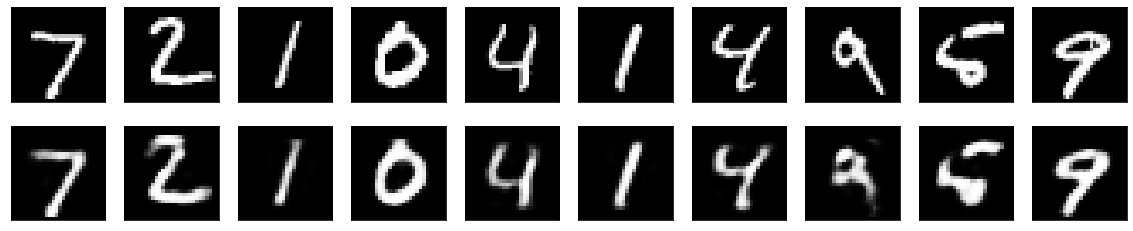

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
